In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 1635525819


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 50,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 155,
    'warmup_factor': 5
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 5,
 'scheduler': 'cosine_schedule_with_warmup',
 'lr_end': 2e-06,
 'power': 0.6,
 'freeze_from_steps': -1,
 'seed': 1635525819,
 'num_epoch': 50,
 'to_freeze_count': 155}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /home/awsw-dev/.cache/huggingface/datasets/text/default-e0c4ced24ae48a04/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


Dataset demo snapshot:
<d><scn>facin2<msg>Ry "You know we'll be back, and if they find anything, there will be consequences."<|endoftext|><p><msg>c "Of course."<|endoftext|><p><msg>c "We're still in the bar. And I just put some pepper there to wake you up."<d><scn>black<msg>Br "That's the best you could come up with?"<|endoftext|><d><scn>np2y<msg>m "Reza wasn't moving when Maverick walked off and came towards me."<|endoftext|><p><msg>
c "Alright, let's forget about time travellers. What if I told you there is another human here besides Reza and me?"<d><scn>o2<msg>Br "This is getting kinda weird, [player_name]."<|endoftext|><p><msg>c "Why?"<|endoftext|><p><msg>c "At least it's not like you were egging me on the whole time. Wait, actually, that is exactly what happened."<d><scn>pad<msg>Br "No, you are right. This was a bad idea all around."<|endoftext|><d><scn>
[0] set freeze_part_layers: True (freezing 155 out of 160 layers.)


Step,Training Loss
53,3.710600
106,2.820000
159,2.540200
212,2.342300
265,2.248700
318,2.235600
371,2.131100
424,2.101300
477,2.037800
530,2.018900


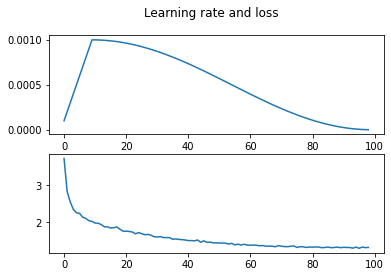

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [8]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<


Prompt: What do you think of Lorem?
Reply: Ad "I think he's a very attractive person."<p><msg>c "I think he's a very attractive person."<d><msg>c "I think he's a very attractive person."<d><msg>c "I think he's a very attractive person."<d><msg>c "I think he's a very attractive person."<d><msg>c "I think he's


Prompt: Oh my god, Adine. What is this?
Reply: Adine looked around the room, but didn't see anything. I looked back at him, but didn't see anything. I looked back again, but didn't see anything. I looked back again, but didn't see anything. I looked back again, but didn't see anything. I looked back again, but didn't see anything. I looked back again, but didn't see anything. I looked back again, but didn't


Prompt: What will we do here?
Reply: black<msg>An "I sat down

# Sampling test

Which combination is the best?

In [9]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 10, top_p: 0.26] -> Prompt: How are you?
Reply: Ry "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<

[Test 1 top_k: 10, top_p: 0.26] -> Prompt: What do you think of Lorem?
Reply: Ad "I think he's a very smart individual. I think he's a very smart individual. I think he's a very smart individual. I think he's a very smart individual. I think he's a very smart individual. I think he's a very smart individual. I think he's a very smart individual. I think he's a very smart individual. I think he's a very smart individual. I think he

[Test 1 top_k: 10, top_p: 0.26] -> Prompt: Oh my god, Adine. What is this?
Reply: Adine's eyes widened with disbelief.<d><scn>cafe<msg>Adine looked around the room, seemingly lost in thought.<d><scn>cafe<msg>Adine seemed genuinely impressed.<d><scn>cafe<msg>Adine seemed genuinely impressed.<d><scn>cafe<msg>Adine se

In [10]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined